In [1]:
%load_ext rpy2.ipython

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from rpy2.robjects import pandas2ri

%matplotlib inline

pandas2ri.activate()

In this chapter we relax the linearity assumption while still attempting to maintain as much interpretability as possible. We do this by examining very simple extensions of linear models like:  

  * *Polynomial regression* extends the linear model by adding extra predictors, obtained by raising each of the original predictors to a power.  
  <br>
  * *Step functions* cut the range of a variable into $K$ distint regions in order to produce a qualitative variable. 
  <br>
  * *Regression splines* are more flexible than polynomials and step functions, and in fact are an extension of the two. They involve dividing the range of $X$ into $K$ distinct regions. Within each region, a polynomial function is fit to the data. These polynomials are constrained so that they join smoothly at the region boundaries, or *knots*.  
  <br>
  * *Smoothing splines* are similar to regression splines, but arise in a slightly different situation. Smoothing splines result from minimizing a residual sum of squarees criterion subject to a smoothness penalty.  
  <br>
  * *Local regression* is similar to spline, but differs in a very important way. The regions are allowed to overlap, and indeed they do so in a very smooth way.  
  <br>
  * *Generalized additive models* allow us to extend the methods above to deal with multiple predictors.  

# Polynomial Regression

Historicall, the standard way to extend linear regression to settings in which the relationship between the predictors and the response is nonlinear has been to replace the standard model  

$$y_i=\beta_0+\beta_1x_i + \epsilon_i$$  

with a polynomial function  

$$y_i = \beta_0+\beta_1x_i + \beta_2x_i^2 + \beta_3x_i^3+...+\beta_dx_i^d+\epsilon_i$$  

where $\epsilon_i$ is the error term. For large enough degree $d$, a polynomial regression can produce an extremely non-linear curve. The coefficients can be easily estimated using least squares linear regression because this is just a standard linear model with predictors $x_i, x_i^2, x_i^3,...,x_i^d$. In general, it is unusual to use $d$ greater than 3 or 4 because for large values of $d$, the polynomial curve can become overly flexible and can take on some strange shapes. 

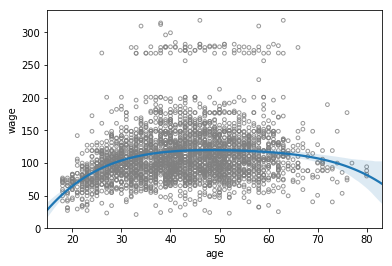

In [2]:
wage = pd.read_csv('../../data/Wage.csv', index_col=0)
wage['wage250'] = 0
wage.loc[wage['wage'] > 250, 'wage250'] = 1

sns.regplot(x=wage['age'], y=wage['wage'], order=4, 
            scatter_kws={'facecolors': 'none', 'edgecolors': 'gray', 's': 14});

Optimization terminated successfully.
         Current function value: 0.116870
         Iterations 12


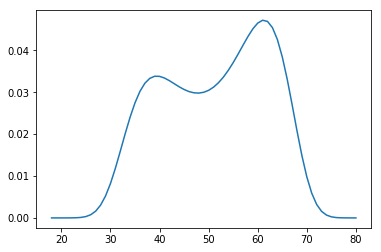

In [43]:
import statsmodels.api as sm
from sklearn.preprocessing import PolynomialFeatures

poly = PolynomialFeatures(degree=4)

age = poly.fit_transform(wage['age'].values.reshape(-1, 1))

logit = sm.Logit(wage['wage250'], age).fit()

age_range_poly = poly.fit_transform(np.arange(18, 81).reshape(-1, 1))

y_proba = logit.predict(age_range_poly)
plt.plot(np.arange(18, 81).reshape(-1, 1), y_proba)

In [44]:
logit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                wage250   No. Observations:                 3000
Model:                          Logit   Df Residuals:                     2995
Method:                           MLE   Df Model:                            4
Date:                Tue, 21 Nov 2017   Pseudo R-squ.:                 0.04013
Time:                        07:13:54   Log-Likelihood:                -350.61
converged:                       True   LL-Null:                       -365.27
                                        LLR p-value:                 6.747e-06
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       -109.5530     47.655     -2.299      0.022    -202.956     -16.150
x1             8.9950      4.187      2.148      0.032       0.789      17.201
x2            -0.2816      0.135     -2.081      0.037      -0.547      -0.016
x3             0.0039      0.002      2.022      0.043       0.000       0.008
x4         -1.949e-05   9.91e-06     -1.966      0.049   -3.89e-05   -6.41e-08
==============================================================================
"""